In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

### まず実験結果の読み込み

In [4]:
targetDir = "../data/output/Result1/Result/"
speedDir = "../data/output/Result1/Speed/"
brakeDir = "../data/output/Result1/Brake/"
accelDIr = "../data/output/Result1/Accel/"
accelOffDir = "../data/output/Result1/AccelOff/"
turnRightDir = "../data/output/Result1/TurnRight/"
turnLeftDir = "../data/output/Result1/TurnLeft/"
manyCarDir = "../data/output/Result1/ManyCars/"
middleCarDir = "../data/output/Result1/MiddleCars/"
lessCarDir = "../data/output/Result1/LessCars/"
afternoonSunMax = "../data/output/Result1/AfternoonSunMax/"
afternoonSunMiddle = "../data/output/Result1/AfternoonSunMiddle/"
afternoonSunMin = "../data/output/Result1/AfternoonSunMin/"
cloudMax = "../data/output/Result1/CloudMax/"
cloudMiddle = "../data/output/Result1/CloudMiddle/"
cloudMin = "../data/output/Result1/CloudMin/"

### 読み込んだデータを元に data-frame を作成

In [5]:
df1 = pd.read_csv(speedDir + "result.csv")
df1.columns = [["id", "slow", "green", "yellow", "red"]]
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(turnRightDir + "result.csv")
df4.columns = [["id", "turnRight"]]
df5 = pd.read_csv(turnLeftDir + "result.csv")
df5.columns = [["id", "turnLeft"]]
df6 = pd.read_csv(afternoonSunMax + "result.csv")
df6.columns = [["id", "sunMax"]]
df7 = pd.read_csv(afternoonSunMiddle + "result.csv")
df7.columns = [["id", "sunMiddle"]]
df8 = pd.read_csv(afternoonSunMin + "result.csv")
df8.columns = [["id", "sunMin"]]
df9 = pd.read_csv(cloudMax + "result.csv")
df9.columns = [["id", "cloudMax"]]
df10 = pd.read_csv(cloudMiddle + "result.csv")
df10.columns = [["id", "cloudMiddle"]]
df11 = pd.read_csv(cloudMin + "result.csv")
df11.columns = [["id", "cloudMin"]]
df12 = pd.read_csv(manyCarDir + "result.csv")
df12.columns = [["id", "manyCars"]]
df13 = pd.read_csv(middleCarDir + "result.csv")
df13.columns = [["id", "middleCars"]]
df14 = pd.read_csv(lessCarDir + "result.csv")
df14.columns = [["id", "lessCars"]]

### Merge

In [6]:
def mergeFrames(dfs, key="id"):
    if len(dfs) == 0:
        return pd.DataFrame()
    
    acc = dfs[0]
    for df in dfs[1:]:
        acc = pd.merge(acc, df, on="id")
        
    return acc

In [7]:
df = mergeFrames([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])
gridSize = len(df)

### Rename

In [8]:
features =  [
    "red",  "yellow",  "green", "slow", 
    "brake", "accel", 
    "turnRight", "turnLeft",
    "sunMax", "sunMiddle", "sunMin",
    "cloudMax", "cloudMiddle", "cloudMin",
    "manyCars", "middleCars", "lessCars"
]

### 必要なデータだけ取り出す (通った経路だけ)

In [9]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['slow'] > 0]
mf = mf[features]
pathIndex = mf.index

### 確認

In [10]:
mf.describe()

,red,yellow,green,slow,brake,accel,turnRight,turnLeft,sunMax,sunMiddle,sunMin,cloudMax,cloudMiddle,cloudMin,manyCars,middleCars,lessCars
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,11.991870,133.609756,78.211382,155.894309,8.634146,18.048780,5.439024,3.260163,101.243902,83.552846,194.910569,134.406504,52.666667,192.634146,65.414634,36.390244,277.902439
std,29.764512,83.804675,116.664311,492.554180,11.072983,14.551691,21.417454,7.070879,136.674397,94.135776,414.956881,168.708490,51.929755,420.551575,72.397234,34.061091,491.127398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,81.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,13.000000,25.500000,62.000000,29.000000,17.000000,46.000000,21.500000,15.000000,85.000000
50%,0.000000,119.000000,12.000000,0.000000,4.000000,15.000000,0.000000,0.000000,43.000000,57.000000,107.000000,79.000000,35.000000,99.000000,37.000000,26.000000,158.000000
75%,3.000000,189.000000,138.500000,71.500000,13.500000,26.000000,2.000000,3.000000,139.500000,107.500000,169.000000,164.500000,71.000000,173.500000,89.000000,46.000000,234.500000
max,129.000000,392.000000,544.000000,3831.000000,57.000000,69.000000,217.000000,46.000000,729.000000,669.000000,3571.000000,914.000000,293.000000,3557.000000,464.000000,209.000000,4040.000000


In [11]:
# colors = [
#   "#FE2400",
#   "#B21D72",
#   "#5023D0",
#   "#247395",
#   "#FFFF01",
#   "#FEAF07",
#   "#247395",
# ]

In [12]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

# VBGMM

### 各特徴料を正規化する下準備

In [13]:
normedFeatures = [
    "red",  "yellow",  "green",
    "brake", "accel", 
    "turnRight", "turnLeft",
    "sunMax", "sunMiddle",
    "cloudMax", "cloudMiddle",
    "manyCars", "middleCars"
]

In [14]:
speeds = ["red", "yellow", "green", "slow"]
pedals = ["brake", "accel"]
steerings = ["turnRight", "turnLeft"]
suns = ["sunMax", "sunMiddle", "sunMin",]
clouds = ["cloudMax", "cloudMiddle", "cloudMin",]
detectCars = ["manyCars", "middleCars", "lessCars"]

### 各特徴料を正規化

In [15]:
bf = mf.copy()
bf["sumSpeed"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"]
bf["sumPedal"] = bf["brake"] + bf["accel"] 
bf["sumSteering"] = bf["turnRight"] + bf["turnLeft"]
bf["sumSuns"] = bf["sunMax"] + bf["sunMiddle"] + bf["sunMin"]
bf["sumClouds"] = bf["cloudMax"] + bf["cloudMiddle"] + bf["cloudMin"]
bf["sumDetect"] = bf["manyCars"] + bf["middleCars"] + bf["lessCars"]

for key in speeds:
    bf[key] = bf[key] / bf["sumSpeed"]
    
for key in pedals:
    bf[key] = bf[key] / bf["sumPedal"]
    
for key in steerings:
    bf[key] = bf[key] / bf["sumSteering"]

for key in suns:
    bf[key] = bf[key] /bf["sumSuns"]
    
for key in clouds:
    bf[key] = bf[key] /bf["sumClouds"]

for key in detectCars:
    bf[key] = bf[key] /bf["sumDetect"]
    
bf = bf.fillna(0)    
    
# bf = bf[features]
bf = bf[normedFeatures]

In [16]:
bf.describe()

,red,yellow,green,brake,accel,turnRight,turnLeft,sunMax,sunMiddle,cloudMax,cloudMiddle,manyCars,middleCars
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.080068,0.590656,0.173269,0.226762,0.756977,0.234854,0.244820,0.260159,0.250583,0.363240,0.173227,0.196625,0.116595
std,0.173157,0.339190,0.210690,0.222738,0.241463,0.395369,0.401927,0.183125,0.120910,0.200093,0.096777,0.108029,0.046423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015075,0.000000,0.000000,0.000000
25%,0.000000,0.284895,0.000000,0.000000,0.608696,0.000000,0.000000,0.086923,0.158286,0.190014,0.102174,0.130467,0.086857
50%,0.000000,0.566667,0.058252,0.200000,0.777778,0.000000,0.000000,0.259259,0.246575,0.399314,0.160237,0.167127,0.112821
75%,0.019141,0.941462,0.310593,0.385354,1.000000,0.356250,0.468750,0.404749,0.311382,0.487189,0.232524,0.243448,0.146257
max,0.592593,1.000000,1.000000,0.954545,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.581818,0.235294


### ハイパーパラメータの設定

In [17]:
components = 24
prior = 0.01
cov_type = 'full'
cov_prior = 0.2 * np.identity(len(normedFeatures))
max_iter = 200

### 一番良い seed 値をグリッドサーチする

In [18]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=max_iter
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 18, 'lower bounds': 7166.9326633171331, 'seed': 11},
 {'classes': 17, 'lower bounds': 7180.0364612897592, 'seed': 8},
 {'classes': 16, 'lower bounds': 7189.2709140622146, 'seed': 15},
 {'classes': 16, 'lower bounds': 7193.7590541953496, 'seed': 17},
 {'classes': 15, 'lower bounds': 7220.4974807038625, 'seed': 18},
 {'classes': 15, 'lower bounds': 7221.7400064268695, 'seed': 7},
 {'classes': 15, 'lower bounds': 7230.622175064228, 'seed': 6},
 {'classes': 15, 'lower bounds': 7233.4086144387766, 'seed': 19},
 {'classes': 15, 'lower bounds': 7235.8111434919556, 'seed': 12},
 {'classes': 14, 'lower bounds': 7239.433004545991, 'seed': 14},
 {'classes': 15, 'lower bounds': 7258.8401625934712, 'seed': 5},
 {'classes': 14, 'lower bounds': 7263.1403492014188, 'seed': 2},
 {'classes': 15, 'lower bounds': 7273.0904196716183, 'seed': 3},
 {'classes': 12, 'lower bounds': 7278.3014448927788, 'seed': 0},
 {'classes': 14, 'lower bounds': 7290.3853863772756, 'seed': 10},
 {'classes': 13, 'l

### 上で得られた一番良いシード値に設定

In [19]:
sd = 8
np.random.seed(sd)
random.seed(sd)

### 実際に Bayesian Gaussian Mixture mode でクラスタリング

In [20]:
vb = BayesianGaussianMixture(
    n_components=components,
    weight_concentration_prior=prior, 
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    max_iter=max_iter    
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       17
classes:           set([0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 21, 22, 23])
lower bound:  7180.03646129


### 結果の確認

In [21]:
vb.weights_

array([ 0.10522494,  0.00799225,  0.00792087,  0.01565282,  0.02333584,
        0.15454867,  0.01522044,  0.03722428,  0.00744786,  0.01466433,
        0.02909073,  0.01436559,  0.07169486,  0.13344569,  0.09618301,
        0.01337603,  0.00651555,  0.01269506,  0.00617951,  0.00601593,
        0.00585669,  0.06299673,  0.07561843,  0.07673388])

In [22]:
ws = ["%02f" % w for w in vb.weights_]

In [23]:
ref = pd.DataFrame(vb.means_)
ref.columns = [normedFeatures]
ref["slow"] = 1 - (ref["red"] + ref["yellow"] + ref["green"])
ref["sunMin"] = 1 - (ref["sunMax"] + ref["sunMiddle"])
ref["cloudMin"] = 1 - (ref["cloudMax"] + ref["cloudMiddle"])
ref["lessCars"] = 1 - (ref["manyCars"] + ref["middleCars"])
ref["weight"] = ws
ref.sort_values("weight", ascending=False)

,red,yellow,green,brake,accel,turnRight,turnLeft,sunMax,sunMiddle,cloudMax,cloudMiddle,manyCars,middleCars,slow,sunMin,cloudMin,lessCars,weight
5,0.442268,0.539298,0.010114,0.024474,0.974715,0.011713,0.012210,0.086631,0.182183,0.250770,0.133029,0.160237,0.123316,0.008320,0.731186,0.616201,0.716446,0.154549
13,0.004196,0.274686,0.299397,0.323153,0.675995,0.012307,0.012829,0.426296,0.230511,0.509409,0.197964,0.189852,0.100880,0.421721,0.343193,0.292626,0.709268,0.133446
0,0.008754,0.872142,0.099084,0.110497,0.888257,0.030395,0.929728,0.154951,0.223951,0.248681,0.127890,0.151338,0.124655,0.020020,0.621098,0.623429,0.724007,0.105225
14,0.005711,0.179273,0.296486,0.397735,0.601105,0.892063,0.070824,0.255005,0.230405,0.355137,0.118540,0.163122,0.085672,0.518529,0.514589,0.526323,0.751205,0.096183
23,0.005382,0.426111,0.380062,0.365349,0.633564,0.105383,0.859839,0.368718,0.312392,0.471599,0.227464,0.252332,0.129727,0.188445,0.318890,0.300937,0.617941,0.076734
22,0.042380,0.889458,0.039961,0.099114,0.899704,0.017070,0.017794,0.385330,0.250417,0.459343,0.214152,0.232914,0.126174,0.028202,0.364253,0.326505,0.640913,0.075618
12,0.012508,0.926155,0.041057,0.154165,0.844227,0.023235,0.024221,0.065337,0.248295,0.089831,0.113075,0.260994,0.136365,0.020280,0.686368,0.797094,0.602641,0.071695
21,0.022519,0.894891,0.066535,0.111913,0.886615,0.772156,0.180751,0.237866,0.331690,0.389919,0.218700,0.195901,0.121231,0.016056,0.430444,0.391381,0.682868,0.062997
7,0.016211,0.771736,0.156022,0.348083,0.648625,0.845030,0.049623,0.306983,0.338139,0.438669,0.253219,0.267630,0.137864,0.056031,0.354878,0.308113,0.594505,0.037224
10,0.038034,0.813325,0.109636,0.676732,0.319203,0.058713,0.061204,0.318390,0.227028,0.401146,0.196868,0.279186,0.149030,0.039005,0.454582,0.401985,0.571784,0.029091


In [24]:
ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))]

,red,yellow,green,brake,accel,turnRight,turnLeft,sunMax,sunMiddle,cloudMax,cloudMiddle,manyCars,middleCars,slow,sunMin,cloudMin,lessCars,weight
5,0.442268,0.539298,0.010114,0.024474,0.974715,0.011713,0.012210,0.086631,0.182183,0.250770,0.133029,0.160237,0.123316,0.008320,0.731186,0.616201,0.716446,0.154549
13,0.004196,0.274686,0.299397,0.323153,0.675995,0.012307,0.012829,0.426296,0.230511,0.509409,0.197964,0.189852,0.100880,0.421721,0.343193,0.292626,0.709268,0.133446
0,0.008754,0.872142,0.099084,0.110497,0.888257,0.030395,0.929728,0.154951,0.223951,0.248681,0.127890,0.151338,0.124655,0.020020,0.621098,0.623429,0.724007,0.105225
14,0.005711,0.179273,0.296486,0.397735,0.601105,0.892063,0.070824,0.255005,0.230405,0.355137,0.118540,0.163122,0.085672,0.518529,0.514589,0.526323,0.751205,0.096183
23,0.005382,0.426111,0.380062,0.365349,0.633564,0.105383,0.859839,0.368718,0.312392,0.471599,0.227464,0.252332,0.129727,0.188445,0.318890,0.300937,0.617941,0.076734
22,0.042380,0.889458,0.039961,0.099114,0.899704,0.017070,0.017794,0.385330,0.250417,0.459343,0.214152,0.232914,0.126174,0.028202,0.364253,0.326505,0.640913,0.075618
12,0.012508,0.926155,0.041057,0.154165,0.844227,0.023235,0.024221,0.065337,0.248295,0.089831,0.113075,0.260994,0.136365,0.020280,0.686368,0.797094,0.602641,0.071695
21,0.022519,0.894891,0.066535,0.111913,0.886615,0.772156,0.180751,0.237866,0.331690,0.389919,0.218700,0.195901,0.121231,0.016056,0.430444,0.391381,0.682868,0.062997
7,0.016211,0.771736,0.156022,0.348083,0.648625,0.845030,0.049623,0.306983,0.338139,0.438669,0.253219,0.267630,0.137864,0.056031,0.354878,0.308113,0.594505,0.037224
10,0.038034,0.813325,0.109636,0.676732,0.319203,0.058713,0.061204,0.318390,0.227028,0.401146,0.196868,0.279186,0.149030,0.039005,0.454582,0.401985,0.571784,0.029091


# Plot histgram of each clusters

### ヒストグラムの表示と保存

In [25]:
cls = ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))].index

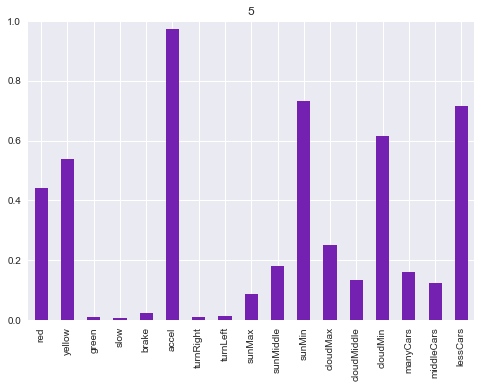

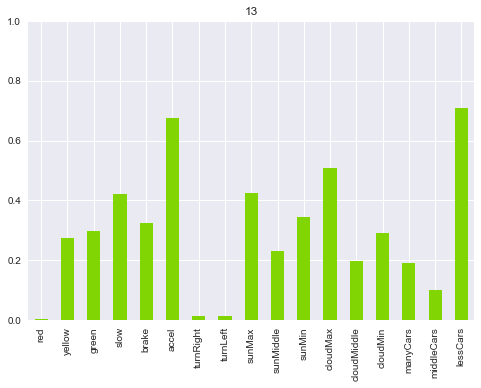

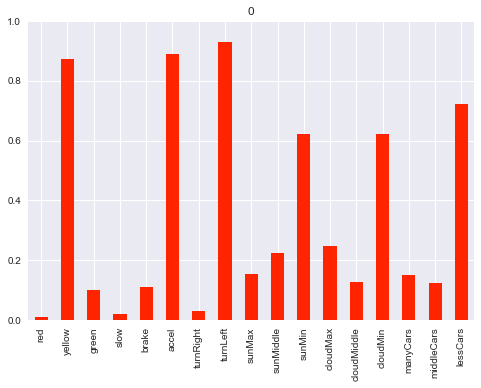

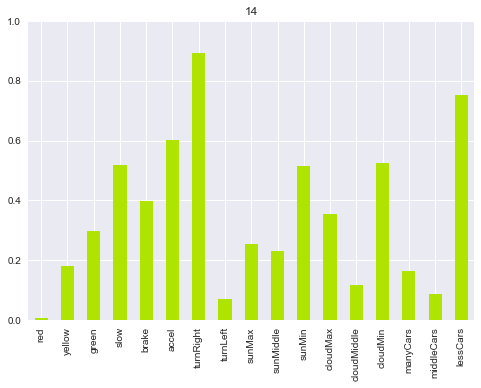

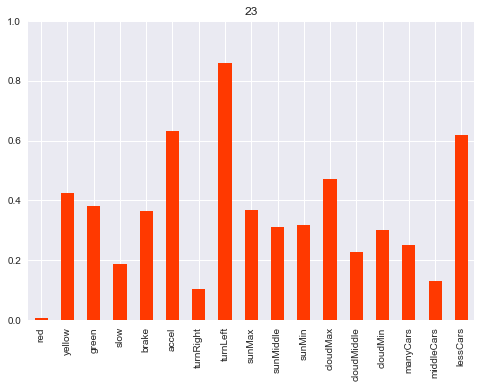

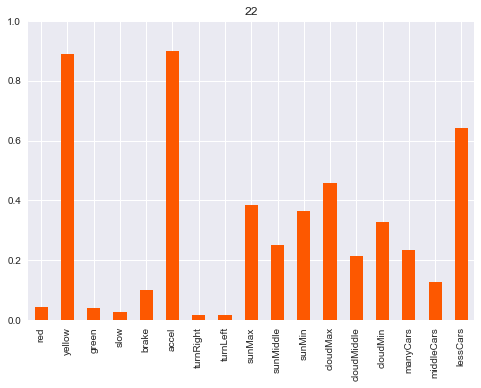

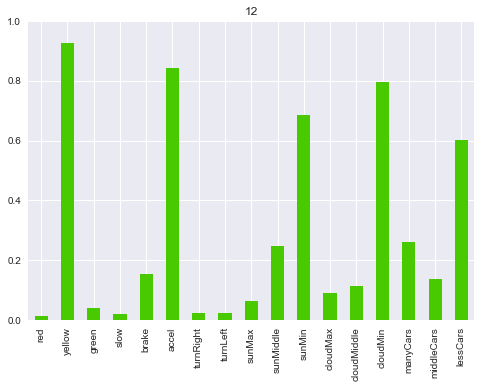

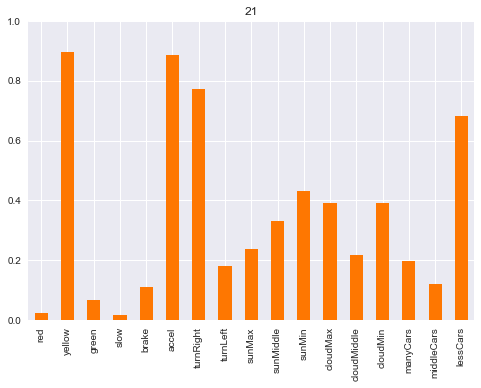

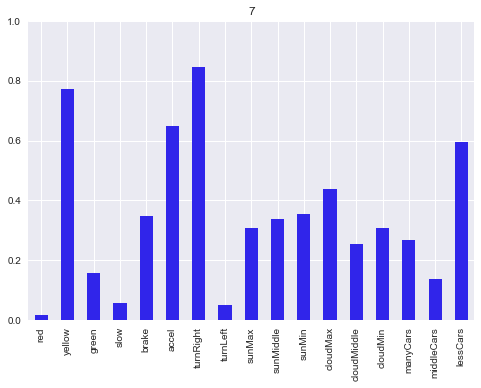

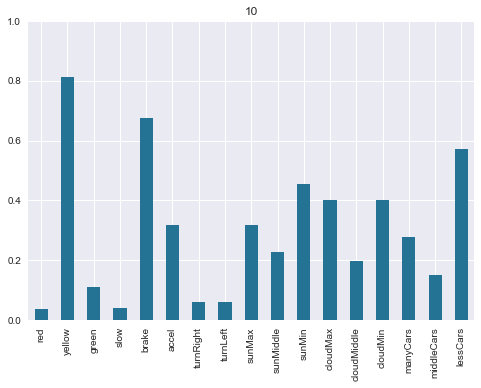

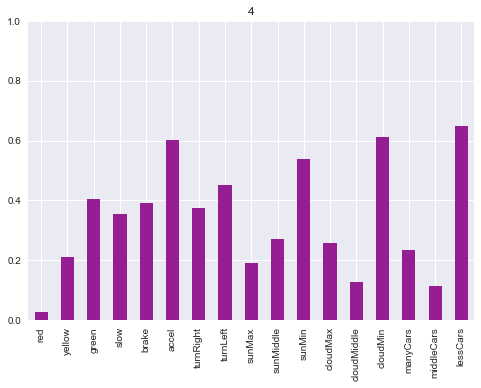

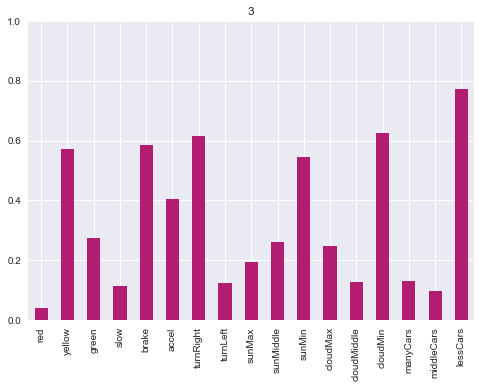

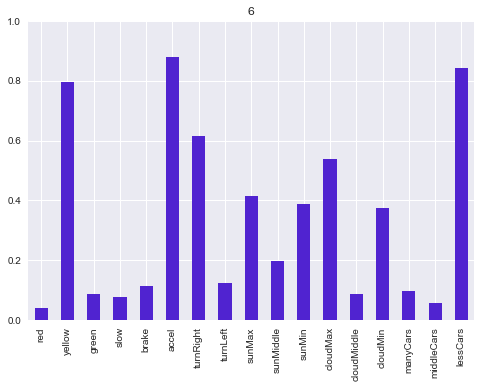

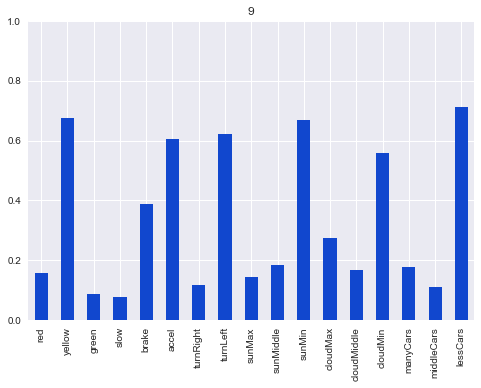

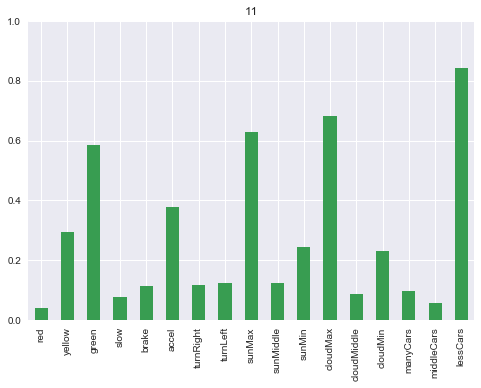

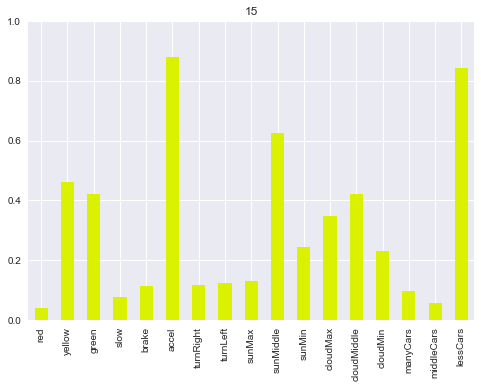

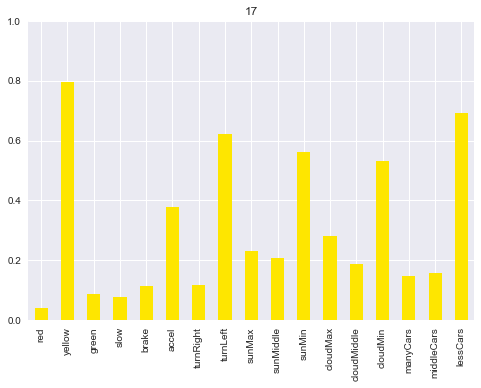

In [36]:
dir = "./img/Result1/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)

ref = ref[features]
for i in cls:
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.title(i)
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

### 結果の保存

In [47]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)

# Display Top-5

In [28]:
normedFeatures = [
    "red",  "yellow",  "green",
    "brake", "accel", "accelOff",
    "turnRight", "turnLeft",
    "sunMax", "sunMiddle",
    "cloudMax", "cloudMiddle",
    "manyCars", "middleCars"
]

In [29]:
top10Index = [511, 223, 249, 277, 252, 253, 633, 251, 244, 214]

In [30]:
top10Color = vb.predict(bf.ix[top10Index])

In [31]:
df16 = pd.read_csv(accelOffDir + "result.csv")
df16.columns = [["id", "accelOff"]]
df16 = df16.ix[pathIndex]

In [32]:
cf = pd.concat([bf, df16], axis=1)
maxAccelOff = cf["accelOff"].sum()
cf["accelOff"] = cf["accelOff"] / maxAccelOff
cf = cf[normedFeatures]

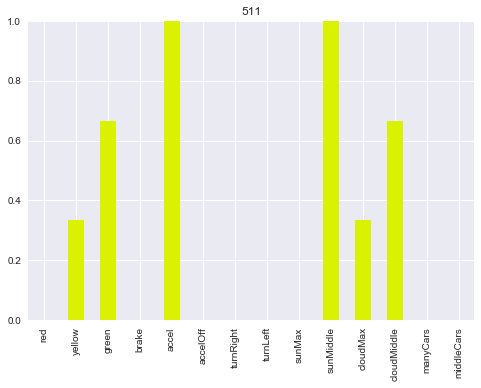

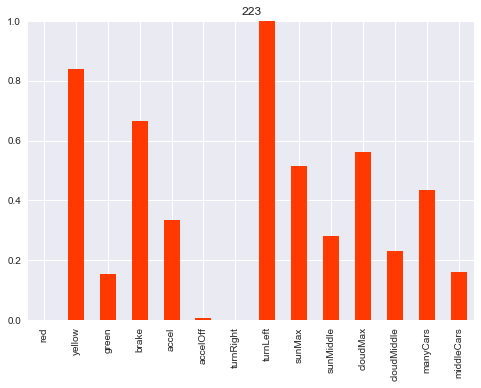

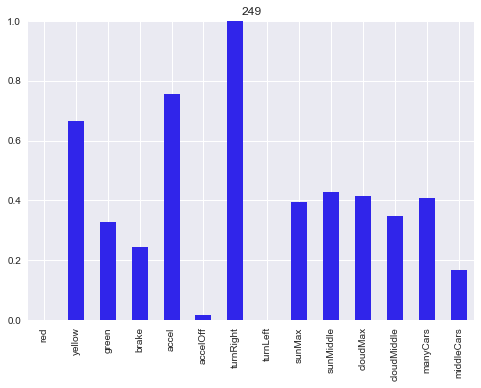

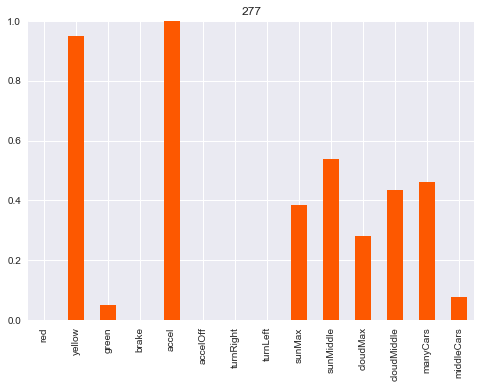

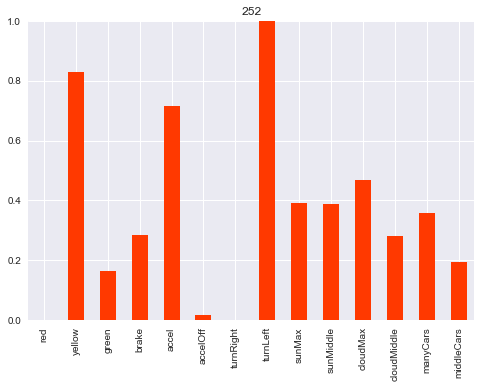

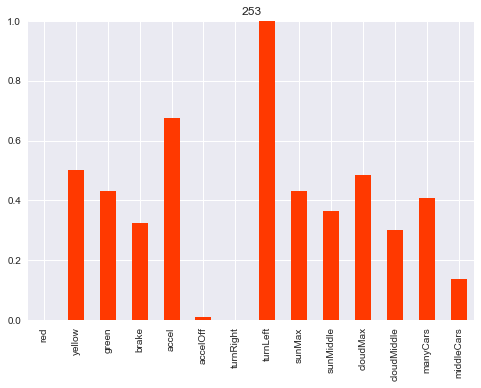

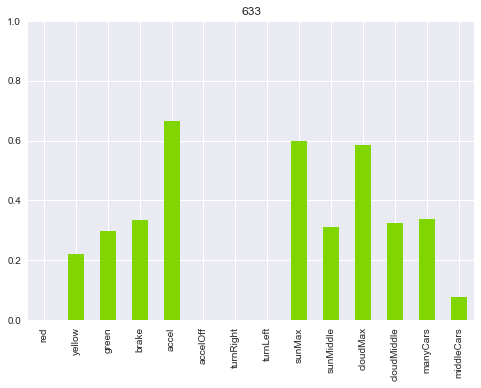

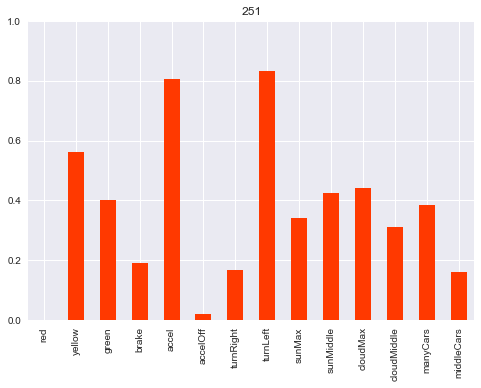

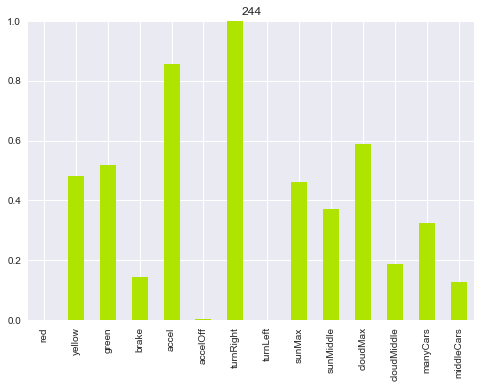

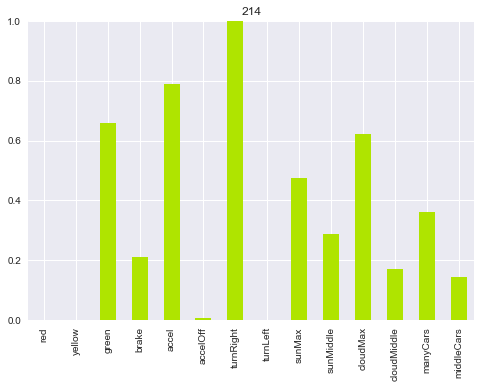

In [35]:
dir = "./img/Result1/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)
    
for i, ic in enumerate(zip(top10Index, top10Color)):
    cf.ix[ic[0]].plot(kind='bar', color=colors[ic[1]])
    plt.ylim(0, 1)
    plt.title(str(top10Index[i]))
    plt.savefig(dir + "/top10-" + str(i+1) + ".png")
    plt.show()

In [38]:
overheadLines = [758, 731, 732, 763]

In [42]:
overheadLineColors = vb.predict(bf.ix[overheadLines])

In [46]:
overheadLineColors

array([21,  5,  5,  6])

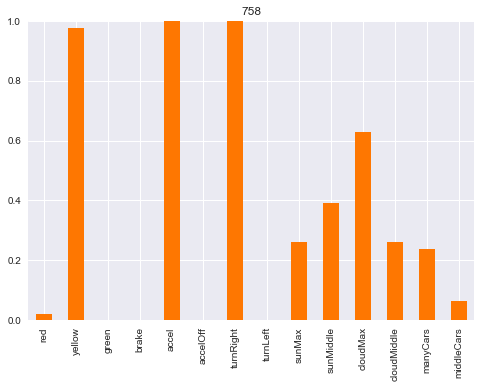

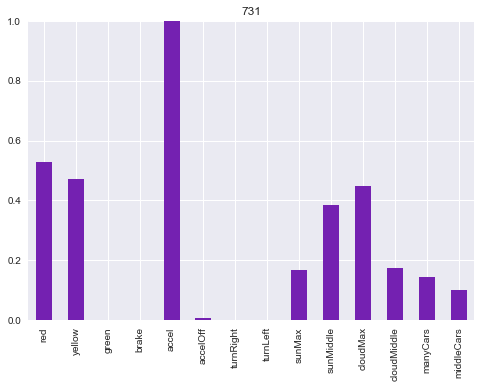

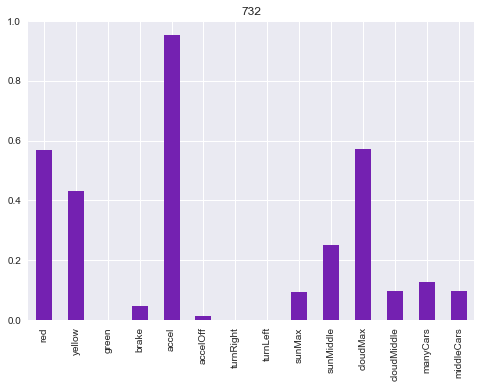

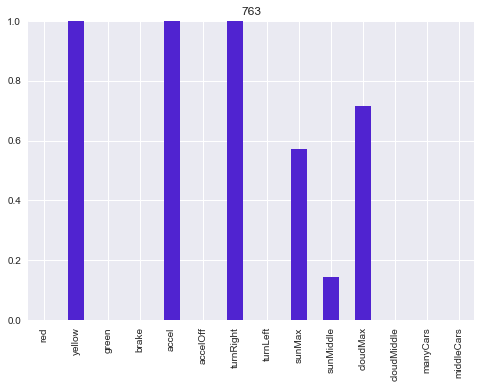

In [45]:
for i, ic in enumerate(zip(overheadLines, overheadLineColors)):
    cf.ix[ic[0]].plot(kind='bar', color=colors[ic[1]])
    plt.ylim(0, 1)
    plt.title(str(overheadLines[i]))
    plt.savefig(dir + "/overheadLines-" + str(i+1) + ".png")
    plt.show()